In [30]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import special
from scipy import interpolate
import plotsettings
import pandas as pd

# Foreground data

*recalculate RLU with new Tobs(full O3 runtime) for the O3a-O3a pairs and combine all the pairs.*

In [2]:
o3b_ab_foreground = pd.read_csv('../data/O3_fg_bayes_factors.txt',delimiter='\t',header = 0,names=['event1','event2','blu','rlu'])

In [3]:
o3b_ab_foreground

event1     event2            blu     rlu
0     GW190408_181802  S190403cj   2.520000e-18  8.7900
1     GW190408_181802   S190426l   0.000000e+00  2.5300
2     GW190408_181802   S190725t   0.000000e+00  0.0000
3     GW190408_181802  S190805bq  6.590000e-254  0.0000
4     GW190408_181802  S190916al   3.310000e-34  0.0000
...               ...        ...            ...     ...
2252        S200322ab  S191219ax   2.430000e+00  0.0201
2253        S200322ab   S191222n   2.440000e+00  0.0203
2254        S200322ab   S200208q   1.150000e+00  0.4330
2255        S200322ab  S200224ca   6.790000e-01  1.4100
2256        S200322ab   S200302c   7.520000e-01  2.1600

[2257 rows x 4 columns]

In [4]:
o3b_ab_foreground['log10_blu']=np.log10(o3b_ab_foreground['blu']+1e-6)
o3b_ab_foreground['log10_rlu']=np.log10(o3b_ab_foreground['rlu']+1e-6)
o3b_ab_foreground['log10_combined_bf'] =o3b_ab_foreground['log10_blu'] + o3b_ab_foreground['log10_rlu']

In [5]:
o3a_pairs = pd.read_csv('/home/srashti.goyal/lensid-ml-O3/blu/O3a_blu_final.txt',delim_whitespace=True,header = 0,names=['event1','event2','blu','rlu_o3a'])

In [6]:
o3a_pairs

event1           event2            blu  rlu_o3a
0    GW190408_181802         GW190412  9.140000e-259    6.540
1    GW190408_181802  GW190413_052954   0.000000e+00    5.820
2    GW190408_181802  GW190413_134308  7.920000e-215    5.380
3    GW190408_181802  GW190421_213856  5.270000e-211    2.220
4    GW190408_181802  GW190424_180648   1.360000e-26    1.800
..               ...              ...            ...      ...
698  GW190930_133541  GW190828_065509  8.200000e-108    0.507
699  GW190930_133541  GW190909_114149   6.460000e-82    1.150
700  GW190930_133541  GW190910_112807   0.000000e+00    1.260
701  GW190930_133541  GW190924_021846   0.000000e+00    4.320
702  GW190930_133541  GW190929_012149   0.000000e+00    8.960

[703 rows x 4 columns]

In [7]:
events_info = pd.read_csv('/home/srashti.goyal/lensid-ml-O3/events_df_info.csv')

In [8]:
events_info.tail()

Unnamed: 0  Unnamed: 0.1 CatDev Name     SNAME         FULLNAME  \
83          83            83   GW200308A  S200308a  GW200308_173609   
84          84            84   GW200311B  S200311b  GW200311_115853   
85          85            85   GW200316A  S200316a  GW200316_215756   
86          86            86   GW200322A  S200322a  GW200322_091133   
87          87            87   GW200326A  S200326a  GW200326_112501   

              NNAME  MINIMALNAME GRACEDBSID  IS PUBLIC?  CWB ONLY?  ...  \
83  GW200308_173609     GW200308  S200308bl       False      False  ...   
84  GW200311_115853  GW200311_11  S200311bg        True      False  ...   
85  GW200316_215756     GW200316  S200316bj        True      False  ...   
86  GW200322_091133     GW200322  S200322ab       False      False  ...   
87  GW200326_112501     GW200326  S200326af       False       True  ...   

     mass2 L1  mchirp L1   mtotal L1  template_duration L1    snr V1  \
83  34.847599  41.906761  102.818770              4.399324  2.133489   
84  32.121094  29.053270   66.805939              2.704791  7.292044   
85   4.943711  10.775739   41.868874             11.333138  3.119627   
86  15.137034  24.386002   71.318713              0.720487  2.242833   
87        NaN        NaN         NaN                   NaN       NaN   

     mass1 V1   mass2 V1  mchirp V1   mtotal V1  template_duration V1  
83  67.971169  34.847599  41.906761  102.818770              4.399324  
84  34.684841  32.121094  29.053270   66.805939              2.704791  
85  36.925163   4.943711  10.775739   41.868874             11.333138  
86  56.181679  15.137034  24.386002   71.318713              0.720487  
87        NaN        NaN        NaN         NaN                   NaN  

[5 rows x 30 columns]

In [9]:
O3_dict = dict(zip(events_info['NNAME'].values,events_info['GRACEDBSID'].values))
O3_dict['GW190426_152155']='S190426c'
O3_dict['GW190424_180648'] = 'S190424ao'
O3_dict['GW200220_124850'] = 'S200220aw'
O3_dict['GW190909_114149']='S190909w'

In [10]:
o3a_pairs['consistent_event_tag1'] = o3a_pairs['event1']
ids=np.where(o3a_pairs['consistent_event_tag1'].str.startswith("GW")==True)[0]
o3a_pairs['consistent_event_tag1'][ids] = [O3_dict[event1]  for event1 in o3a_pairs['event1'].values[ids]] 


o3a_pairs['consistent_event_tag2'] = o3a_pairs['event2']
ids=np.where(o3a_pairs['consistent_event_tag2'].str.startswith("GW")==True)[0]
o3a_pairs['consistent_event_tag2'][ids] = [O3_dict[event1]  for event1 in o3a_pairs['event2'].values[ids]] 


/home/srashti.goyal/.conda/envs/igwn-py37-hanabi/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/srashti.goyal/.conda/envs/igwn-py37-hanabi/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [11]:
o3a_pairs.head()

event1           event2            blu  rlu_o3a  \
0  GW190408_181802         GW190412  9.140000e-259     6.54   
1  GW190408_181802  GW190413_052954   0.000000e+00     5.82   
2  GW190408_181802  GW190413_134308  7.920000e-215     5.38   
3  GW190408_181802  GW190421_213856  5.270000e-211     2.22   
4  GW190408_181802  GW190424_180648   1.360000e-26     1.80   

  consistent_event_tag1 consistent_event_tag2  
0             S190408an              S190412m  
1             S190408an              S190413i  
2             S190408an             S190413ac  
3             S190408an             S190421ar  
4             S190408an             S190424ao

In [12]:
o3b_ab_foreground['consistent_event_tag1'] = o3b_ab_foreground['event1']
ids=np.where(o3b_ab_foreground['consistent_event_tag1'].str.startswith("GW")==True)[0]
o3b_ab_foreground['consistent_event_tag1'][ids] = [O3_dict[event1]  for event1 in o3b_ab_foreground['event1'].values[ids]] 


o3b_ab_foreground['consistent_event_tag2'] = o3b_ab_foreground['event2']
ids=np.where(o3b_ab_foreground['consistent_event_tag2'].str.startswith("GW")==True)[0]
o3b_ab_foreground['consistent_event_tag2'][ids] = [O3_dict[event1]  for event1 in o3b_ab_foreground['event2'].values[ids]] 



/home/srashti.goyal/.conda/envs/igwn-py37-hanabi/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/srashti.goyal/.conda/envs/igwn-py37-hanabi/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [13]:
o3b_ab_foreground.head()

event1     event2            blu   rlu  log10_blu  log10_rlu  \
0  GW190408_181802  S190403cj   2.520000e-18  8.79       -6.0   0.943989   
1  GW190408_181802   S190426l   0.000000e+00  2.53       -6.0   0.403121   
2  GW190408_181802   S190725t   0.000000e+00  0.00       -6.0  -6.000000   
3  GW190408_181802  S190805bq  6.590000e-254  0.00       -6.0  -6.000000   
4  GW190408_181802  S190916al   3.310000e-34  0.00       -6.0  -6.000000   

   log10_combined_bf consistent_event_tag1 consistent_event_tag2  
0          -5.056011             S190408an             S190403cj  
1          -5.596879             S190408an              S190426l  
2         -12.000000             S190408an              S190725t  
3         -12.000000             S190408an             S190805bq  
4         -12.000000             S190408an             S190916al

In [14]:
O3_time_dict = dict(zip(events_info['GRACEDBSID'].values,events_info['gpstime'].values))
O3_time_dict['S190426c'] = 1240327333.33654
O3_time_dict['S190424ao'] = 1240164426.141708
O3_time_dict['S200220aw'] = 1266238148.153809
O3_time_dict['S190909w'] = 1252064527.739946


In [15]:
o3a_pairs['event1_tgps'] = [O3_time_dict[event]  for event in o3a_pairs['consistent_event_tag1'].values] 
o3a_pairs['event2_tgps'] = [O3_time_dict[event]  for event in o3a_pairs['consistent_event_tag2'].values] 


In [16]:
o3b_ab_foreground['event1_tgps'] = [O3_time_dict[event]  for event in o3b_ab_foreground['consistent_event_tag1'].values] 
o3b_ab_foreground['event2_tgps'] = [O3_time_dict[event]  for event in o3b_ab_foreground['consistent_event_tag2'].values] 



In [17]:
o3b_ab_foreground.head()

event1     event2            blu   rlu  log10_blu  log10_rlu  \
0  GW190408_181802  S190403cj   2.520000e-18  8.79       -6.0   0.943989   
1  GW190408_181802   S190426l   0.000000e+00  2.53       -6.0   0.403121   
2  GW190408_181802   S190725t   0.000000e+00  0.00       -6.0  -6.000000   
3  GW190408_181802  S190805bq  6.590000e-254  0.00       -6.0  -6.000000   
4  GW190408_181802  S190916al   3.310000e-34  0.00       -6.0  -6.000000   

   log10_combined_bf consistent_event_tag1 consistent_event_tag2  \
0          -5.056011             S190408an             S190403cj   
1          -5.596879             S190408an              S190426l   
2         -12.000000             S190408an              S190725t   
3         -12.000000             S190408an             S190805bq   
4         -12.000000             S190408an             S190916al   

    event1_tgps   event2_tgps  
0  1.238783e+09  1.238304e+09  
1  1.238783e+09  1.240341e+09  
2  1.238783e+09  1.248112e+09  
3  1.238783e+09  1.249075e+09  
4  1.238783e+09  1.252700e+09

In [18]:
o3a_pairs.head()

event1           event2            blu  rlu_o3a  \
0  GW190408_181802         GW190412  9.140000e-259     6.54   
1  GW190408_181802  GW190413_052954   0.000000e+00     5.82   
2  GW190408_181802  GW190413_134308  7.920000e-215     5.38   
3  GW190408_181802  GW190421_213856  5.270000e-211     2.22   
4  GW190408_181802  GW190424_180648   1.360000e-26     1.80   

  consistent_event_tag1 consistent_event_tag2   event1_tgps   event2_tgps  
0             S190408an              S190412m  1.238783e+09  1.239082e+09  
1             S190408an              S190413i  1.238783e+09  1.239169e+09  
2             S190408an             S190413ac  1.238783e+09  1.239198e+09  
3             S190408an             S190421ar  1.238783e+09  1.239918e+09  
4             S190408an             S190424ao  1.238783e+09  1.240164e+09

In [82]:
import calc_rlu

In [20]:
#i=40
#tc1,tc2=o3a_pairs['event1_tgps'][i],o3a_pairs['event2_tgps'][i]
#tc1,tc2=o3b_ab_foreground['event1_tgps'][i],o3b_ab_foreground['event2_tgps'][i]
o3a_pairs['rlu']=[calc_rlu.rlu_haris_way_tc1_tc2(o3a_pairs['event1_tgps'][i],o3a_pairs['event2_tgps'][i]) for i in range(len(o3a_pairs))]

In [21]:
#plt.scatter(o3a_pairs['rlu'], o3a_pairs['rlu_o3a'])

In [22]:
o3a_pairs['log10_blu']=np.log10(o3a_pairs['blu']+1e-6)
o3a_pairs['log10_rlu']=np.log10(o3a_pairs['rlu']+1e-6)
o3a_pairs['log10_combined_bf'] =o3a_pairs['log10_blu'] + o3a_pairs['log10_rlu']

In [23]:
o3a_pairs.tail()

event1           event2            blu  rlu_o3a  \
698  GW190930_133541  GW190828_065509  8.200000e-108    0.507   
699  GW190930_133541  GW190909_114149   6.460000e-82    1.150   
700  GW190930_133541  GW190910_112807   0.000000e+00    1.260   
701  GW190930_133541  GW190924_021846   0.000000e+00    4.320   
702  GW190930_133541  GW190929_012149   0.000000e+00    8.960   

    consistent_event_tag1 consistent_event_tag2   event1_tgps   event2_tgps  \
698              S190930s              S190828l  1.253886e+09  1.251011e+09   
699              S190930s              S190909w  1.253886e+09  1.252065e+09   
700              S190930s              S190910s  1.253886e+09  1.252150e+09   
701              S190930s              S190924h  1.253886e+09  1.253327e+09   
702              S190930s              S190929d  1.253886e+09  1.253755e+09   

           rlu  log10_blu  log10_rlu  log10_combined_bf  
698   0.833575       -6.0  -0.079055          -6.079055  
699   1.959239       -6.0   0.292088          -5.707912  
700   2.168641       -6.0   0.336188          -5.663812  
701   7.692163       -6.0   0.886049          -5.113951  
702  16.156561       -6.0   1.208349          -4.791651

In [24]:
O3_all_pairs=pd.concat([o3b_ab_foreground,o3a_pairs]).reset_index(drop=True)

In [25]:
O3_all_pairs.tail()

event1           event2            blu        rlu  log10_blu  \
2955  GW190930_133541  GW190828_065509  8.200000e-108   0.833575       -6.0   
2956  GW190930_133541  GW190909_114149   6.460000e-82   1.959239       -6.0   
2957  GW190930_133541  GW190910_112807   0.000000e+00   2.168641       -6.0   
2958  GW190930_133541  GW190924_021846   0.000000e+00   7.692163       -6.0   
2959  GW190930_133541  GW190929_012149   0.000000e+00  16.156561       -6.0   

      log10_rlu  log10_combined_bf consistent_event_tag1  \
2955  -0.079055          -6.079055              S190930s   
2956   0.292088          -5.707912              S190930s   
2957   0.336188          -5.663812              S190930s   
2958   0.886049          -5.113951              S190930s   
2959   1.208349          -4.791651              S190930s   

     consistent_event_tag2   event1_tgps   event2_tgps  rlu_o3a  
2955              S190828l  1.253886e+09  1.251011e+09    0.507  
2956              S190909w  1.253886e+09  1.252065e+09    1.150  
2957              S190910s  1.253886e+09  1.252150e+09    1.260  
2958              S190924h  1.253886e+09  1.253327e+09    4.320  
2959              S190929d  1.253886e+09  1.253755e+09    8.960

In [26]:
O3_candidate_pairs=O3_all_pairs[O3_all_pairs['blu']>50].reset_index(drop=True)
O3_candidate_pairs.sort_values('log10_combined_bf',ascending=False).reset_index(drop=True)

event1           event2      blu        rlu  log10_blu  \
0          S191105e         S191103a    980.0  13.700000   2.991226   
1   GW190728_064510  GW190930_133541  60200.0   0.127472   4.779596   
2   GW190930_133541         S191105e   4150.0   0.728000   3.618048   
3   GW190731_140936  GW190803_022701    119.0  13.747938   2.075547   
4   GW190706_222641  GW190719_215514    308.0   3.946518   2.488551   
5   GW190803_022701  GW190910_112807   1520.0   0.659949   3.181844   
6   GW190424_180648  GW190413_052954    139.0   4.409123   2.143015   
7         S200219ac        S200209ab     97.3   5.310000   1.988113   
8   GW190720_000836  GW190728_064510     79.9   6.210884   1.902547   
9         S190805bq        S190916al    995.0   0.464000   2.997823   
10         S191204h         S191215w     91.1   4.430000   1.959518   
11  GW190731_140936  GW190910_112807    161.0   0.481694   2.206826   
12  GW190424_180648  GW190521_074359     50.9   1.402771   1.706718   
13  GW190620_030421        S190805bq    150.0   0.399000   2.176091   
14  GW190930_133541         S191204r    458.0   0.129000   2.660865   
15         S191204r         S191103a     61.9   0.895000   1.791691   
16         S200128d         S191222n     74.7   0.688000   1.873321   
17  GW190707_093326  GW190930_133541    914.0   0.039902   2.960946   
18  GW190731_140936         S190926d    146.0   0.212000   2.164353   
19  GW190630_185205  GW190513_205428     81.8   0.371029   1.912753   
20  GW190727_060333  GW190910_112807     62.1   0.410074   1.793092   
21  GW190915_235702  GW190719_215514     63.4   0.185277   1.802089   
22  GW190620_030421        S190916al    266.0   0.026700   2.424882   
23  GW190731_140936  GW190421_213856    621.0   0.009624   2.793092   
24  GW190720_000836  GW190930_133541     51.0   0.085531   1.707570   
25  GW190727_060333  GW190424_180648    212.0   0.020020   2.326336   
26  GW190708_232457         GW190412    130.0   0.030696   2.113943   
27  GW190424_180648  GW190803_022701     56.6   0.009694   1.752816   
28  GW190909_114149         S191222n     71.2   0.006820   1.852480   
29  GW190513_205428         S200302c   2370.0   0.000000   3.374748   
30  GW190426_152155         S200115j   2350.0   0.000000   3.371068   
31  GW190413_052954        S200219ac    909.0   0.000000   2.958564   
32  GW190915_235702         S200112r    803.0   0.000000   2.904716   
33  GW190421_213856         S191222n    767.0   0.000000   2.884795   
34  GW190527_092055         S200112r    676.0   0.000000   2.829947   
35  GW190424_180648        S200224ca    596.0   0.000000   2.775246   
36  GW190803_022701        S200219ac    446.0   0.000000   2.649335   
37  GW190527_092055         S200129m    421.0   0.000000   2.624282   
38  GW190803_022701        S200209ab    255.0   0.000000   2.406540   
39  GW190910_112807         S200128d    245.0   0.000000   2.389166   
40  GW190413_052954        S200209ab    223.0   0.000000   2.348305   
41  GW190421_213856         S190926d    219.0   0.000000   2.340444   
42  GW190413_134308         S191109d    163.0   0.000000   2.212188   
43  GW190701_203306        S200220aw    143.0   0.000000   2.155336   
44  GW190424_180648  GW190910_112807    130.0   0.000000   2.113943   
45  GW190421_213856  GW190910_112807     95.5   0.000000   1.980003   
46  GW190620_030421        S200216br     71.5   0.000000   1.854306   
47  GW190727_060333        S200209ab     70.5   0.000000   1.848189   
48  GW190602_175927        S191230an     65.5   0.000000   1.816241   
49  GW190701_203306        S191230an     62.7   0.000000   1.797268   
50  GW190424_180648         S200208q     61.8   0.000000   1.790988   
51  GW190909_114149        S200209ab     57.1   0.000000   1.756636   
52  GW190514_065416        S190916al     56.8   0.000000   1.754348   
53  GW190424_180648         S190926d     51.2   0.000000   1.709270   

    log10_rlu  log10_combined_bf consistent_event_tag1 consistent_event_tag2  \
0    1.136721           4.1

### Highest combined log Bayes factor: S191105e-S191103a : 4.13

In [57]:
O3_all_pairs.to_csv('O3_all_pairs_PO.csv')

# Background data for getting significance

*Time shift the background injections over full O3 and get new RLU of the background*

In [27]:
data_bg = pd.read_csv('../data/bg_bayes_factors.txt',delimiter='\t',header = 0,names=['event1','event2','blu','rlu_haris','rlu_anupreeta'])


In [28]:
data_bg.tail()

event1       event2  blu  rlu_haris  rlu_anupreeta
483675   b'154_3332'  b'287_6478'  0.0     0.0906         0.7230
483676  b'555_12168'  b'356_8141'  0.0     0.0358         0.1850
483677   b'204_4567'  b'368_8296'  0.0     0.6480         4.3400
483678   b'101_2087'  b'113_2381'  0.0     0.0112         0.0000
483679  b'722_17163'  b'383_8492'  0.0     0.0182         0.0415

In [29]:
# rlu background 
unlensed_td_mag_samples=pd.read_csv('/home/srashti.goyal/o3_forsrashti/unlensedpairs_1yr_tdmag_O3.txt',delim_whitespace=True,names=['td_days','mag'])

In [30]:
#np.min(o3a_pairs['event1_tgps'])

In [31]:
unlensed_td_mag_samples.tail()

td_days       mag
19995  175.220785  0.275994
19996  205.108243  0.037326
19997   26.079016  3.905345
19998   21.756043  0.180330
19999   24.251803  0.320007

In [32]:
unlensed_td_mag_samples['td_secs']=unlensed_td_mag_samples['td_days']*24*3600

In [33]:
tc1=1238782700.28818

In [34]:
unlensed_td_mag_samples['rlu_haris_way']=[calc_rlu.rlu_haris_way_tc1_tc2(tc1,tc1+td) for td in unlensed_td_mag_samples['td_secs']]


In [35]:
unlensed_td_mag_samples.tail()

td_days       mag       td_secs  rlu_haris_way
19995  175.220785  0.275994  1.513908e+07       0.000000
19996  205.108243  0.037326  1.772135e+07       0.000000
19997   26.079016  3.905345  2.253227e+06       1.417237
19998   21.756043  0.180330  1.879722e+06       1.882396
19999   24.251803  0.320007  2.095356e+06       1.612172

In [36]:
unlensed_td_mag_samples['log10rlu_haris_way']=np.log10(unlensed_td_mag_samples['rlu_haris_way']+1e-6)

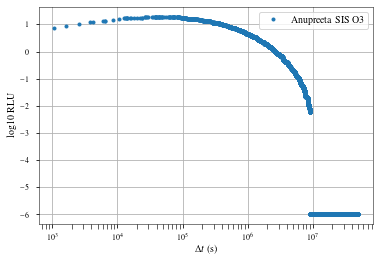

In [37]:
plt.plot(unlensed_td_mag_samples['td_secs'],unlensed_td_mag_samples['log10rlu_haris_way'],'.',label='Anupreeta SIS O3')
plt.grid()
plt.xscale('log')
plt.legend()
plt.ylabel('log10 RLU')
plt.xlabel('$\Delta t$ (s)')
plt.show()

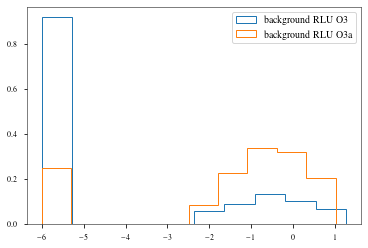

In [38]:
plt.hist(unlensed_td_mag_samples['log10rlu_haris_way'],label='background RLU O3 ',density=True,histtype='step')
plt.hist(np.log10(data_bg['rlu_anupreeta']+1e-6),label='background RLU O3a',density=True,histtype='step')
plt.legend()
plt.show()

In [39]:
from random import sample
rlu_bg = unlensed_td_mag_samples['rlu_haris_way'].values
lc_bg = np.log10(sample(list(data_bg['blu']),len(rlu_bg))*rlu_bg+1e-6)

In [40]:
min(lc_bg), max(lc_bg)

(-6.0, 4.1992415607028954)

In [41]:
# Catalog FAP vs Threshold 
min(lc_bg), max(lc_bg)
b = np.linspace(-6, 6, 10000)
hh, bb = np.histogram(lc_bg,bins=b,density=True)
dc = bb[1]-b[0]
sim_BluRlu = 0.5*(bb[1:]+b[:-1])
sim_fap = 1-np.cumsum(hh)*dc
#plt.plot(sim_BluRlu,sim_fap)

N_events = 81
N_pairs = 2258

cat_fap = 1-np.power(1-sim_fap, N_pairs) # FAP for catalogue = 1-(1-FAP_{pair})^N; where N= number of pairs
sim_BluRlu_of_fap = interpolate.interp1d(cat_fap, sim_BluRlu)

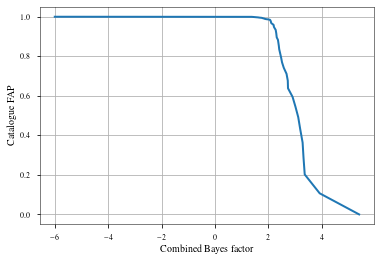

In [42]:
plt.plot(sim_BluRlu_of_fap(cat_fap), cat_fap)
plt.grid()
plt.xlabel('Combined Bayes factor')
plt.ylabel('Catalogue FAP')
plt.show()

In [43]:
T = 28605600
i_file = '../scripts/o3_fap/test_injections_Dominik_LHV_withsnr.dat'
data = np.genfromtxt(i_file, names=True)
day = 60 * 60 * 24.0
extra_days = int(T / day)
t0_det=data["t0"][np.where(data['snr']>8)]
t_ext = np.random.randint(extra_days, size=len(t0_det)) * day
t_shifted = t0_det + t_ext

In [44]:
t_shifted.min(),t_shifted.max()

(1249872723.89061, 1278355619.84235)

In [51]:
ul_tc_samples = np.array(sample(list(t_shifted),1000))

In [52]:
ul_tc_df = pd.DataFrame()

In [54]:
from itertools import combinations
comb = np.array(list(combinations(np.arange(1000), 2)))
npairs = comb.shape[0]

ul_tc_df['tc1'] = ul_tc_samples[comb[:, 0]]
ul_tc_df['tc2'] = ul_tc_samples[comb[:, 1]]

In [55]:
ul_tc_df['rlu_haris_way_O3']=[calc_rlu.rlu_haris_way_tc1_tc2(ul_tc_df['tc1'][i],ul_tc_df['tc2'][i]) for i in range(len(ul_tc_df))]


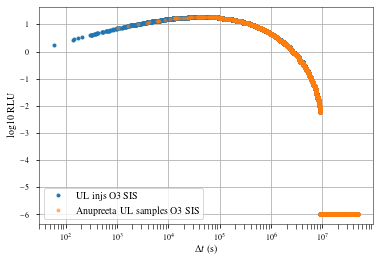

In [76]:
plt.plot(np.abs(ul_tc_df['tc1']-ul_tc_df['tc2']),np.log10(ul_tc_df['rlu_haris_way_O3']+1e-6),'.',label='UL injs O3 SIS')
plt.plot(unlensed_td_mag_samples['td_secs'],unlensed_td_mag_samples['log10rlu_haris_way'],'.',label='Anupreeta UL samples O3 SIS',alpha=0.5)


plt.grid()
plt.xscale('log')
plt.legend()
plt.ylabel('log10 RLU')
plt.xlabel('$\Delta t$ (s)')
plt.show()

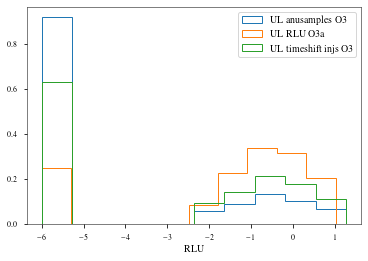

In [56]:
plt.hist(unlensed_td_mag_samples['log10rlu_haris_way'],label=' UL anusamples O3 ',density=True,histtype='step')
plt.hist(np.log10(data_bg['rlu_anupreeta']+1e-6),label=' UL RLU O3a',density=True,histtype='step')
plt.hist(np.log10(ul_tc_df['rlu_haris_way_O3']+1e-6),label=' UL timeshift injs O3',density=True,histtype='step')
plt.xlabel('RLU')

plt.legend()
plt.show()

In [78]:
unlensed_td_mag_samples.to_csv('anu_ul_td_samples_O3.csv')
ul_tc_df.to_csv('ul_O3_tc_injs.csv')

In [59]:
lc_bg = np.log10(data_bg['blu']*ul_tc_df['rlu_haris_way_O3']+1e-6)

In [77]:
ul_tc_df['blu_o3a_injs'] = data_bg['blu']
ul_tc_df['log10com_blu_o3a_injs_rlu_haris_way_O3']=np.log10(data_bg['blu']*ul_tc_df['rlu_haris_way_O3']+1e-6)

In [60]:
min(lc_bg), max(lc_bg)

(-6.0, 5.908571285982809)

In [63]:
# Catalog FAP vs Threshold 
min(lc_bg), max(lc_bg)
b = np.linspace(-6, 8, 10000)
hh, bb = np.histogram(lc_bg,bins=b,density=True)
dc = bb[1]-b[0]
sim_BluRlu = 0.5*(bb[1:]+b[:-1])
sim_fap = 1-np.cumsum(hh)*dc
#plt.plot(sim_BluRlu,sim_fap)

N_events = 81
N_pairs = 2258

cat_fap = 1-np.power(1-sim_fap, N_pairs) # FAP for catalogue = 1-(1-FAP_{pair})^N; where N= number of pairs
sim_BluRlu_of_fap = interpolate.interp1d(cat_fap, sim_BluRlu)

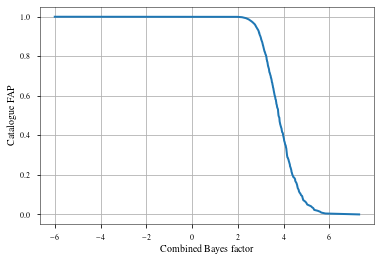

In [64]:
plt.plot(sim_BluRlu_of_fap(cat_fap), cat_fap)
plt.grid()
plt.xlabel('Combined Bayes factor')
plt.ylabel('Catalogue FAP')
plt.show()

In [66]:
sigma = 2**-0.5
sim_BluRlu_of_fap(special.erfc(sigma)),sim_BluRlu_of_fap(special.erfc(2*sigma))

(array(4.13277313), array(5.08576705))

In [10]:
tc2=1262198446.21287
tc1=1261764316.403643
rlu_sup_sub = calc_rlu.rlu_haris_way_tc1_tc2(tc1,tc2)

In [11]:
(rlu_sup_sub)

9.366006575913755

In [12]:
2.7+np.log10(rlu_sup_sub)

3.6715544583662036

# RLU with Anupreeta's SIE lensed samples 
*Calculate RLU with SIE lensed samples for the foreground and the background*

In [58]:
SIE_anu = dict(np.load('/home/srashti.goyal/o3_forsrashti/SIE_anu.npz'))

In [59]:
SIE_anu.keys()

dict_keys(['mag_0', 'td_0', 'mag_piBy2', 'td_piBy2'])

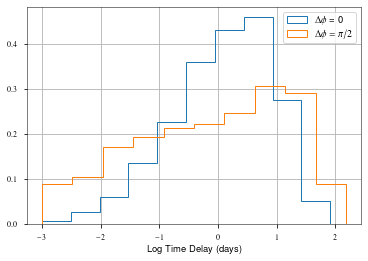

In [60]:
plt.hist(np.log10(SIE_anu['td_0']),histtype='step',label='$\Delta \phi$ = 0 ' ,density=True)
plt.hist(np.log10(SIE_anu['td_piBy2']),histtype='step',label='$\Delta \phi = \pi/2 $',density=True)
plt.legend()
plt.grid()
plt.xlabel('Log Time Delay (days)')
plt.show()

In [61]:
from scipy.stats import gaussian_kde

kde_SIE_anu_td_phi0=gaussian_kde(np.log10(SIE_anu['td_0']),bw_method=0.1)
kde_SIE_anu_td_phi_piBy2=gaussian_kde(np.log10(SIE_anu['td_piBy2']),bw_method=0.1)

In [62]:
import calc_rlu

In [66]:
tc2=1262198446.21287
tc1=1261764316.403643
calc_rlu.rlu_kde_SIE_anu_O3(tc1,tc2,kde_SIE_anu_td_phi0),calc_rlu.rlu_kde_SIE_anu_O3(tc1,tc2,kde_SIE_anu_td_phi_piBy2)

(array([7.03102335]), array([3.92249229]))

In [8]:
fg_df = pd.read_csv('O3_all_pairs_PO.csv',index_col=0)
fg_df.tail()

event1           event2            blu        rlu  log10_blu  \
2955  GW190930_133541  GW190828_065509  8.200000e-108   0.833575       -6.0   
2956  GW190930_133541  GW190909_114149   6.460000e-82   1.959239       -6.0   
2957  GW190930_133541  GW190910_112807   0.000000e+00   2.168641       -6.0   
2958  GW190930_133541  GW190924_021846   0.000000e+00   7.692163       -6.0   
2959  GW190930_133541  GW190929_012149   0.000000e+00  16.156561       -6.0   

      log10_rlu  log10_combined_bf consistent_event_tag1  \
2955  -0.079055          -6.079055              S190930s   
2956   0.292088          -5.707912              S190930s   
2957   0.336188          -5.663812              S190930s   
2958   0.886049          -5.113951              S190930s   
2959   1.208349          -4.791651              S190930s   

     consistent_event_tag2   event1_tgps   event2_tgps  rlu_o3a  
2955              S190828l  1.253886e+09  1.251011e+09    0.507  
2956              S190909w  1.253886e+09  1.252065e+09    1.150  
2957              S190910s  1.253886e+09  1.252150e+09    1.260  
2958              S190924h  1.253886e+09  1.253327e+09    4.320  
2959              S190929d  1.253886e+09  1.253755e+09    8.960

In [10]:
bg_df = pd.read_csv('ul_O3_tc_injs.csv',index_col=0)
bg_df.head()

tc1           tc2  rlu_haris_way_O3  blu_o3a_injs  \
0  1.254818e+09  1.263570e+09          0.009754      0.000029   
1  1.254818e+09  1.267784e+09          0.000000      0.000000   
2  1.254818e+09  1.274321e+09          0.000000      0.000000   
3  1.254818e+09  1.273228e+09          0.000000      0.000000   
4  1.254818e+09  1.264437e+09          0.000000      0.333000   

   log10com_blu_o3a_injs_rlu_haris_way_O3  
0                               -5.891489  
1                               -6.000000  
2                               -6.000000  
3                               -6.000000  
4                               -6.000000

In [11]:
bg_df['rlu_SIE_anu_dphi_0']=calc_rlu.rlu_kde_SIE_anu_O3(bg_df['tc1'],bg_df['tc2'],kde_SIE_anu_td_phi0)

In [12]:
bg_df['rlu_SIE_anu_dphi_piBy2']=calc_rlu.rlu_kde_SIE_anu_O3(bg_df['tc1'],bg_df['tc2'],kde_SIE_anu_td_phi_piBy2)

In [13]:
fg_df['rlu_SIE_anu_dphi_0']=calc_rlu.rlu_kde_SIE_anu_O3(fg_df['event1_tgps'],fg_df['event2_tgps'],kde_SIE_anu_td_phi0)
fg_df['rlu_SIE_anu_dphi_piBy2']=calc_rlu.rlu_kde_SIE_anu_O3(fg_df['event1_tgps'],fg_df['event2_tgps'],kde_SIE_anu_td_phi_piBy2)


In [14]:
fg_df.to_csv('O3_all_pairs_PO.csv')
bg_df.to_csv('ul_O3_tc_injs.csv')

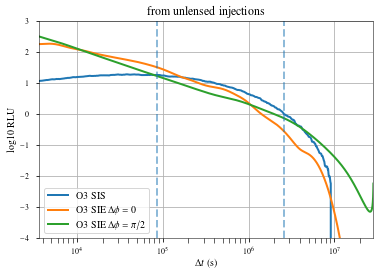

In [37]:
dt_sort=np.sort(np.abs(bg_df['tc1']-bg_df['tc2']))
dt_sort_ids=np.argsort(np.abs(bg_df['tc1']-bg_df['tc2']))
plt.plot(dt_sort,np.log10(bg_df['rlu_haris_way_O3']+1e-10)[dt_sort_ids],label=' O3 SIS')
plt.plot(dt_sort,np.log10(bg_df['rlu_SIE_anu_dphi_0']+1e-10)[dt_sort_ids],label=' O3 SIE $\Delta \phi = $ 0')
plt.plot(dt_sort,np.log10(bg_df['rlu_SIE_anu_dphi_piBy2']+1e-10)[dt_sort_ids],label=' O3 SIE $\Delta \phi =  \pi/2$')
plt.grid()
plt.xscale('log')
plt.legend()
plt.ylim(-4,3)
plt.axvline(24*3600,ls='dashed',alpha=0.5)
plt.axvline(30*24*3600,ls='dashed',alpha=0.5)
plt.xlim(3600,11*30*24*3600)
plt.title('from unlensed injections')
plt.ylabel('log10 RLU')
plt.xlabel('$\Delta t$ (s)')
plt.show()

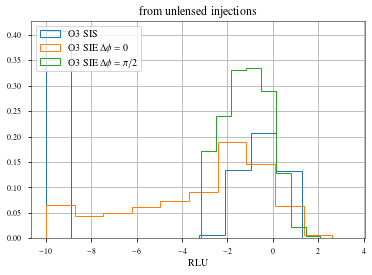

In [38]:
plt.hist(np.log10(bg_df['rlu_haris_way_O3']+1e-10),label=' O3 SIS',density=True,histtype='step')
plt.hist(np.log10(bg_df['rlu_SIE_anu_dphi_0']+1e-10),label='O3 SIE $\Delta \phi = $ 0',density=True,histtype='step')
plt.hist(np.log10(bg_df['rlu_SIE_anu_dphi_piBy2']+1e-10),label='O3 SIE $\Delta \phi =  \pi/2$',density=True,histtype='step')
plt.xlabel('RLU')
plt.grid()
plt.title('from unlensed injections')
plt.legend()
plt.show()

# Compare the results of SIS and SIE for the full O3 

*get the combined RLUs and significance of all O3 pairs with different lens models*

In [4]:
fg_df = pd.read_csv('O3_all_pairs_PO.csv',index_col=0)
fg_df.tail()

event1           event2            blu        rlu  log10_blu  \
2955  GW190930_133541  GW190828_065509  8.200000e-108   0.833575       -6.0   
2956  GW190930_133541  GW190909_114149   6.460000e-82   1.959239       -6.0   
2957  GW190930_133541  GW190910_112807   0.000000e+00   2.168641       -6.0   
2958  GW190930_133541  GW190924_021846   0.000000e+00   7.692163       -6.0   
2959  GW190930_133541  GW190929_012149   0.000000e+00  16.156561       -6.0   

      log10_rlu  log10_combined_bf consistent_event_tag1  \
2955  -0.079055          -6.079055              S190930s   
2956   0.292088          -5.707912              S190930s   
2957   0.336188          -5.663812              S190930s   
2958   0.886049          -5.113951              S190930s   
2959   1.208349          -4.791651              S190930s   

     consistent_event_tag2   event1_tgps   event2_tgps  rlu_o3a  \
2955              S190828l  1.253886e+09  1.251011e+09    0.507   
2956              S190909w  1.253886e+09  1.252065e+09    1.150   
2957              S190910s  1.253886e+09  1.252150e+09    1.260   
2958              S190924h  1.253886e+09  1.253327e+09    4.320   
2959              S190929d  1.253886e+09  1.253755e+09    8.960   

      rlu_SIE_anu_dphi_0  rlu_SIE_anu_dphi_piBy2  
2955            0.203770                0.641371  
2956            0.619758                1.103368  
2957            0.675285                1.162857  
2958            5.761344                3.331133  
2959           20.365377               11.512280

In [10]:
fg_df['log10_combined_bf_SIE_dphi_0'] = np.log10(fg_df['blu']*fg_df['rlu_SIE_anu_dphi_0']+1e-6)
fg_df['log10_combined_bf_SIE_dphi_piBy2'] = np.log10(fg_df['blu']*fg_df['rlu_SIE_anu_dphi_piBy2']+1e-6)

/home/srashti.goyal/.local/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [11]:
bg_df = pd.read_csv('ul_O3_tc_injs.csv',index_col=0)
bg_df.head()

tc1           tc2  rlu_haris_way_O3  blu_o3a_injs  \
0  1.254818e+09  1.263570e+09          0.009754      0.000029   
1  1.254818e+09  1.267784e+09          0.000000      0.000000   
2  1.254818e+09  1.274321e+09          0.000000      0.000000   
3  1.254818e+09  1.273228e+09          0.000000      0.000000   
4  1.254818e+09  1.264437e+09          0.000000      0.333000   

   log10com_blu_o3a_injs_rlu_haris_way_O3  rlu_SIE_anu_dphi_0  \
0                               -5.891489        2.750588e-03   
1                               -6.000000        1.754106e-05   
2                               -6.000000        3.179259e-09   
3                               -6.000000        1.324910e-08   
4                               -6.000000        1.061048e-03   

   rlu_SIE_anu_dphi_piBy2  
0                0.061209  
1                0.017582  
2                0.002612  
3                0.003559  
4                0.046879

In [12]:
def blurlu_fap_cat(lc_bg,N_pairs=2258,plot=True):
    print(min(lc_bg)-0.5, max(lc_bg)+0.5)
    b = np.linspace(min(lc_bg)-0.5, max(lc_bg)+0.5, 10000)
    hh, bb = np.histogram(lc_bg,bins=b,density=True)
    dc = bb[1]-b[0]
    sim_BluRlu = 0.5*(bb[1:]+b[:-1])
    sim_fap = 1-np.cumsum(hh)*dc
    #plt.plot(sim_BluRlu,sim_fap)
    cat_fap = 1-np.power(1-sim_fap, N_pairs) # FAP for catalogue = 1-(1-FAP_{pair})^N; where N= number of pairs
    sim_BluRlu_of_fap = interpolate.interp1d(cat_fap, sim_BluRlu)
    sigma = 2**-0.5
    one_sig,two_sig=sim_BluRlu_of_fap(special.erfc(sigma)),sim_BluRlu_of_fap(special.erfc(2*sigma))
    print('1 & 2 sigma log 10 combined bayesfactors : ',one_sig,two_sig)
    if plot == True:
        plt.plot(sim_BluRlu_of_fap(cat_fap), cat_fap)
        plt.grid()
        plt.xlabel('Combined Bayes factor')
        plt.ylabel('Catalogue FAP')
        plt.show()
    return sim_BluRlu_of_fap, one_sig,two_sig

-6.5 6.408571285982809
1 & 2 sigma log 10 combined bayesfactors :  4.137235787119385 5.087553502887034


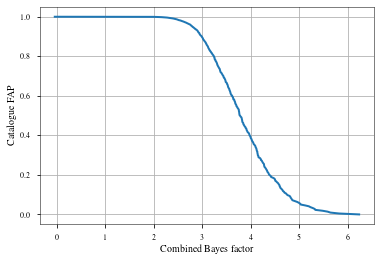

In [13]:
sim_BluRlu_of_fap_O3_SIS,sig1_SIS,sig2_SIS=blurlu_fap_cat(bg_df['log10com_blu_o3a_injs_rlu_haris_way_O3'])

-6.5 6.151856386751589
1 & 2 sigma log 10 combined bayesfactors :  3.9169865286773806 4.924241406334299


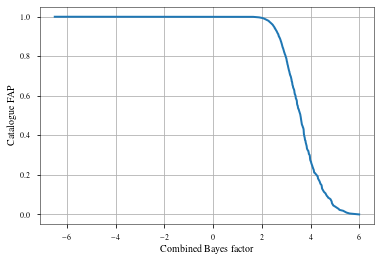

In [14]:
sim_BluRlu_of_fap_O3_SIE_dphi_0,sig1_SIE_dphi_0,sig2_SIE_dphi_0=blurlu_fap_cat(np.log10(bg_df['blu_o3a_injs']*bg_df['rlu_SIE_anu_dphi_0']+ 1e-6))
                                                         
                                                                           

-6.5 6.256090063551873
1 & 2 sigma log 10 combined bayesfactors :  4.010106455934824 4.908908685076889


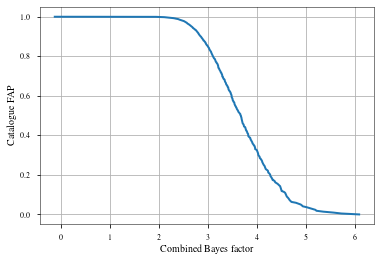

In [15]:
sim_BluRlu_of_fap_O3_SIE_dphi_piBy2,sig1_SIE_dphi_piBy2,sig2_SIE_dphi_piBy2=blurlu_fap_cat(np.log10(bg_df['blu_o3a_injs']*bg_df['rlu_SIE_anu_dphi_piBy2']+ 1e-6))



In [21]:
candidates_df = fg_df[fg_df['blu']>50].reset_index(drop=True)

candidates_df.tail()

event1           event2     blu        rlu  log10_blu  log10_rlu  \
49  GW190731_140936  GW190421_213856   621.0   0.009624   2.793092  -2.016604   
50  GW190731_140936  GW190803_022701   119.0  13.747938   2.075547   1.138238   
51  GW190731_140936  GW190910_112807   161.0   0.481694   2.206826  -0.317227   
52  GW190803_022701  GW190910_112807  1520.0   0.659949   3.181844  -0.180489   
53  GW190915_235702  GW190719_215514    63.4   0.185277   1.802089  -0.732175   

    log10_combined_bf consistent_event_tag1 consistent_event_tag2  \
49           0.776488             S190731aa             S190421ar   
50           3.213785             S190731aa              S190803e   
51           1.889598             S190731aa              S190910s   
52           3.001355              S190803e              S190910s   
53           1.069914             S190915ak             S190719an   

     event1_tgps   event2_tgps  rlu_o3a  rlu_SIE_anu_dphi_0  \
49  1.248617e+09  1.239918e+09  0.00823            0.002908   
50  1.248617e+09  1.248834e+09  7.65000           12.148377   
51  1.248617e+09  1.252150e+09  0.30100            0.102192   
52  1.248834e+09  1.252150e+09  0.40800            0.126441   
53  1.252627e+09  1.247609e+09  0.12400            0.051015   

    rlu_SIE_anu_dphi_piBy2  log10_combined_bf_SIE_dphi_0  \
49                0.062233                      0.256737   
50                7.099047                      3.160065   
51                0.469206                      1.216244   
52                0.520058                      2.283733   
53                0.238774                      0.509791   

    log10_combined_bf_SIE_dphi_piBy2  
49                          1.587114  
50                          2.926747  
51                          1.878189  
52                          2.897895  
53                          1.180076

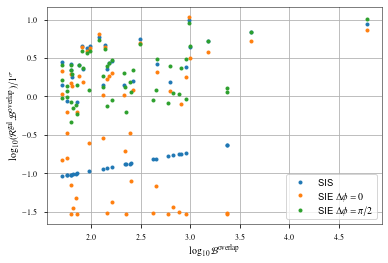

In [29]:
plt.plot(candidates_df['log10_blu'],candidates_df['log10_combined_bf']/sig1_SIS,'.',label='SIS')
plt.plot(candidates_df['log10_blu'],candidates_df['log10_combined_bf_SIE_dphi_0']/sig1_SIE_dphi_0,'.',label='SIE $\Delta \phi = 0 $')
plt.plot(candidates_df['log10_blu'],candidates_df['log10_combined_bf_SIE_dphi_piBy2']/sig1_SIE_dphi_piBy2,'.',label='SIE $\Delta \phi = \pi/2 $')
plt.xlabel('$\log_{10} \mathcal{B}^{\mathrm{overlap}}$')
plt.ylabel('$\log_{10} (\mathcal{R}^{\mathrm{gal}} . \mathcal{B}^{\mathrm{overlap}} )/ 1 ^ \sigma$')
plt.grid()
plt.legend()
plt.show()


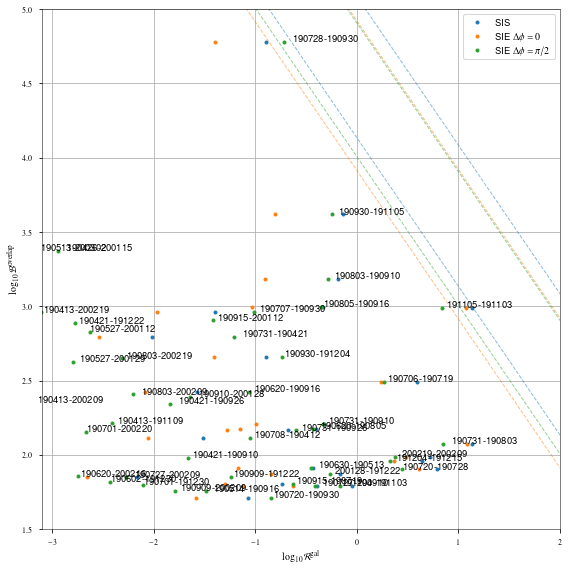

In [53]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif"})
plt.figure(figsize=(8,8))
#plt.figure()
x_vec = np.linspace(-3,5,1000)
plt.plot(x_vec, sig1_SIS-x_vec, lw=1, ls='--', color='C0', alpha=0.5)
plt.plot(x_vec, sig1_SIE_dphi_0-x_vec, lw=1, ls='--', color='C1', alpha=0.5)
plt.plot(x_vec, sig1_SIE_dphi_piBy2-x_vec, lw=1, ls='--', color='C2', alpha=0.5)

plt.plot(x_vec, sig2_SIS-x_vec, lw=1, ls='--', color='C0', alpha=0.5)
plt.plot(x_vec, sig2_SIE_dphi_0-x_vec, lw=1, ls='--', color='C1', alpha=0.5)
plt.plot(x_vec, sig2_SIE_dphi_piBy2-x_vec, lw=1, ls='--', color='C2', alpha=0.5)
candidates_df=candidates_df[candidates_df['consistent_event_tag1'] != 'S190424ao'].reset_index(drop=True)
candidates_df=candidates_df[candidates_df['consistent_event_tag2'] != 'S190424ao'].reset_index(drop=True)


plt.plot(np.log10(candidates_df['rlu']+1e-6),candidates_df['log10_blu'],'.',color='C0',label='SIS')
plt.plot(np.log10(candidates_df['rlu_SIE_anu_dphi_0']+1e-6),candidates_df['log10_blu'],'.',color='C1',label='SIE $\Delta \phi = 0 $')
plt.plot(np.log10(candidates_df['rlu_SIE_anu_dphi_piBy2']+1e-6),candidates_df['log10_blu'],'.',color='C2',label='SIE $\Delta \phi = \pi/2 $')

plt.xlim(-3.1,2.)
plt.legend()
plt.ylim(1.5,5.)
#plt.xlabel('log Bayes factor $\mathcal{R}^\mathrm{L}_\mathrm{U}$')
plt.xlabel('$\log_{10} \mathcal{R}^{\mathrm{gal}}$')
plt.ylabel('$\log_{10} \mathcal{B}^{\mathrm{overlap}}$')
plt.tight_layout()

for i in range(len(candidates_df)):
    ee1=candidates_df['consistent_event_tag1'][i][1:7]
    ee2=candidates_df['consistent_event_tag2'][i][1:7]

    plt.text(np.log10(candidates_df['rlu_SIE_anu_dphi_piBy2'][i]+1e-6)+0.1*(np.random.rand()), candidates_df['log10_blu'][i]+0.005, '{}-{}'.format(ee1,ee2),fontsize=10)



plt.grid()

plt.savefig('lensing_bf_scatterplots_new.png')
plt.show()

In [67]:
lblu=2.7
lrlu_SIS = np.log10(9.366006575913755)
lrlu_SIE_dphi_0 = np.log10(7.03102335)
lrlu_SIE_dphi_piBy2 = np.log10(3.92249229)

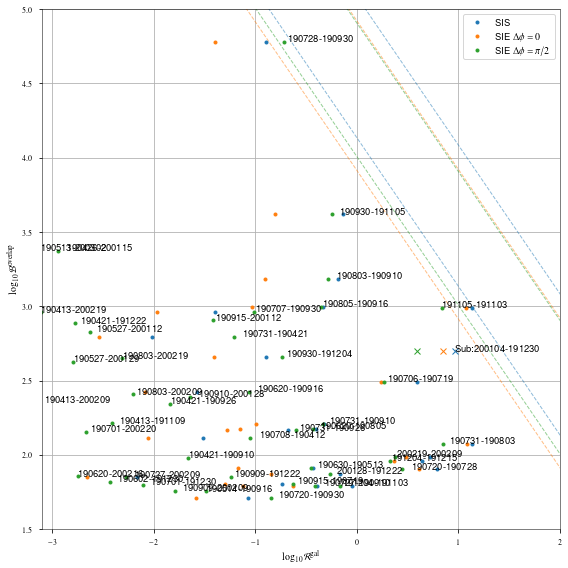

In [71]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif"})
plt.figure(figsize=(8,8))
#plt.figure()
x_vec = np.linspace(-3,5,1000)
plt.plot(x_vec, sig1_SIS-x_vec, lw=1, ls='--', color='C0', alpha=0.5)
plt.plot(x_vec, sig1_SIE_dphi_0-x_vec, lw=1, ls='--', color='C1', alpha=0.5)
plt.plot(x_vec, sig1_SIE_dphi_piBy2-x_vec, lw=1, ls='--', color='C2', alpha=0.5)

plt.plot(x_vec, sig2_SIS-x_vec, lw=1, ls='--', color='C0', alpha=0.5)
plt.plot(x_vec, sig2_SIE_dphi_0-x_vec, lw=1, ls='--', color='C1', alpha=0.5)
plt.plot(x_vec, sig2_SIE_dphi_piBy2-x_vec, lw=1, ls='--', color='C2', alpha=0.5)
candidates_df=candidates_df[candidates_df['consistent_event_tag1'] != 'S190424ao'].reset_index(drop=True)
candidates_df=candidates_df[candidates_df['consistent_event_tag2'] != 'S190424ao'].reset_index(drop=True)

plt.plot(lrlu_SIS,lblu,'x',color='C0')
plt.plot(lrlu_SIE_dphi_0,lblu,'x',color='C1')
plt.plot(lrlu_SIE_dphi_piBy2,lblu,'x',color='C2')




plt.plot(np.log10(candidates_df['rlu']+1e-6),candidates_df['log10_blu'],'.',color='C0',label='SIS')
plt.plot(np.log10(candidates_df['rlu_SIE_anu_dphi_0']+1e-6),candidates_df['log10_blu'],'.',color='C1',label='SIE $\Delta \phi = 0 $')
plt.plot(np.log10(candidates_df['rlu_SIE_anu_dphi_piBy2']+1e-6),candidates_df['log10_blu'],'.',color='C2',label='SIE $\Delta \phi = \pi/2 $')

plt.xlim(-3.1,2.)
plt.ylim(1.5,5.)
#plt.xlabel('log Bayes factor $\mathcal{R}^\mathrm{L}_\mathrm{U}$')
plt.xlabel('$\log_{10} \mathcal{R}^{\mathrm{gal}}$')
plt.ylabel('$\log_{10} \mathcal{B}^{\mathrm{overlap}}$')
plt.tight_layout()

for i in range(len(candidates_df)):
    ee1=candidates_df['consistent_event_tag1'][i][1:7]
    ee2=candidates_df['consistent_event_tag2'][i][1:7]

    plt.text(np.log10(candidates_df['rlu_SIE_anu_dphi_piBy2'][i]+1e-6)+0.1*(np.random.rand()), candidates_df['log10_blu'][i]+0.005, '{}-{}'.format(ee1,ee2),fontsize=10)

plt.text(lrlu_SIS,lblu,'Sub:200104-191230',fontsize=10)

plt.grid()
plt.legend()

plt.savefig('lensing_bf_scatterplots_new_with_sub.png')
plt.show()